<a href="https://colab.research.google.com/github/panghanwu/neural_network_python/blob/main/MLP_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Demo Data - Iris

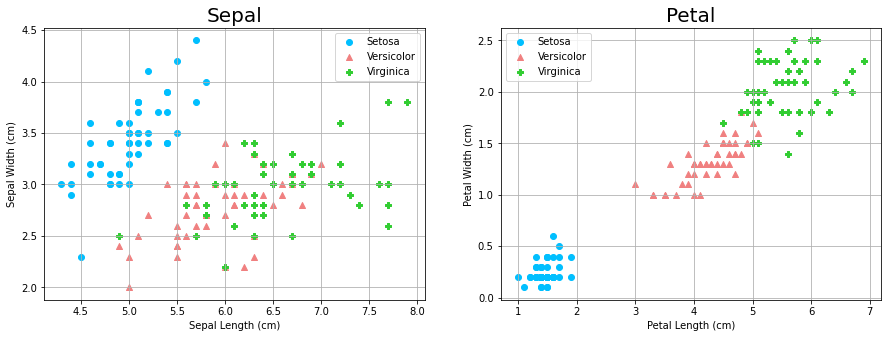

In [1]:
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt

"""Import iris data"""
# load
input_data = load_iris().data
correct = load_iris().target
n_data = len(correct)

# view
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
plt.title('Sepal', fontsize=20)
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.grid()

ax2 = plt.subplot(1,2,2)
plt.title('Petal', fontsize=20)
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.grid()

ax1.scatter(input_data.T[0,:50], input_data.T[1,:50], 
            c='deepskyblue', marker='o', label='Setosa')
ax2.scatter(input_data.T[2,:50], input_data.T[3,:50], 
            c='deepskyblue', marker='o', label='Setosa')

ax1.scatter(input_data.T[0,50:100], input_data.T[1,50:100], 
            c='lightcoral', marker='^', label='Versicolor')
ax2.scatter(input_data.T[2,50:100], input_data.T[3,50:100], 
            c='lightcoral', marker='^', label='Versicolor')

ax1.scatter(input_data.T[0,100:], input_data.T[1,100:], 
            c='limegreen', marker='P', label='Virginica')
ax2.scatter(input_data.T[2,100:], input_data.T[3,100:], 
            c='limegreen', marker='P', label='Virginica')

ax1.legend()
ax2.legend()
plt.show()

## Normalization

Avoid affects due to different scale.

### Standardization

$z = \dfrac{X - \mu}{\sigma}$

In [2]:
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input
input_data[:6]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ],
       [-0.53717756,  1.93979142, -1.16971425, -1.05217993]])

In [3]:
"""One-hot encoding"""
import pandas as pd

correct_data = np.zeros((n_data,3))

for i in range(n_data):
  correct_data[i, correct[i]] = 1.0

pd.DataFrame(correct_data)

,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
145,0.0,0.0,1.0
146,0.0,0.0,1.0
147,0.0,0.0,1.0
148,0.0,0.0,1.0


In [4]:
"""Split"""
# train/test = 50/50
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

input_train = input_data[index_train,:]
correct_train = correct_data[index_train,:]
input_test = input_data[index_test,:]
correct_test = correct_data[index_test,:]

n_train = input_train.shape[0]
n_test = input_test.shape[0]

print(n_train, n_test)

75 75


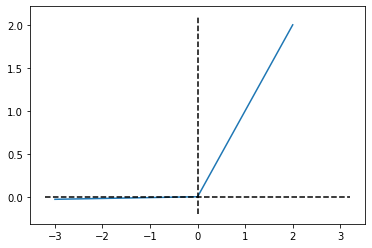

In [5]:
"""Leaky ReLU"""

x_relu = np.arange(-3,3,1)
y_relu = np.where(x_relu < 0, 0.01*x_relu, x_relu)


plt.plot(x_relu, y_relu)
plt.plot((-3.2,3.2), (0,0), 'k--')
plt.plot((0,0), (-0.2,2.1), 'k--')

## Structure
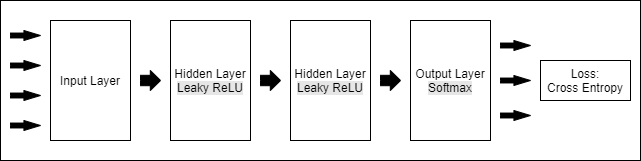

In [6]:
"""Build neural network"""
# parameter
n_in = 4
n_mid = 25
n_out = 3

wb_width = 0.1
eta = 0.01
epoch = 1000
batch_size = 8
interval = 100

# father class
class BaseLayer:
  def __init__(self, n_upper, n):
    self.w = wb_width * np.random.randn(n_upper, n)
    self.b = wb_width * np.random.randn(n)
  
  def update(self, eta):
    self.w -= eta * self.grad_w
    self.b -= eta * self.grad_b

# child class
class MiddleLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.where(self.u < 0, 0.01*self.u, self.u)
  
  def backward(self, grad_y):
    delta = grad_y*np.where(self.u < 0, 0.01, 1)
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)

class OutputLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    u = np.dot(x, self.w) + self.b
    self.y = np.exp(u) / np.sum(np.exp(u), axis=1, keepdims=True)
  
  def backward(self, t):
    delta = self.y - t
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)

# create network
middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# define process
def forward_propagation(x):
  middle_layer_1.forward(x)
  middle_layer_2.forward(middle_layer_1.y)
  output_layer.forward(middle_layer_2.y)

def backpropagation(t):
  output_layer.backward(t)
  middle_layer_2.backward(output_layer.grad_x)
  middle_layer_1.backward(middle_layer_2.grad_x)

def update_wb():
  middle_layer_1.update(eta)
  middle_layer_2.update(eta)
  output_layer.update(eta)

# metric
def get_loss(t, batch_size):
  cross_entropy = t * np.log(output_layer.y+1e-7)
  return -np.sum(cross_entropy) / batch_size

def get_accuracy(answer, predict):
  result = np.argmax(answer, axis=1) == np.argmax(predict, axis=1)
  return np.sum(result)

Epoch:0/1000 train_loss:1.098082 test_loss:1.097955
Epoch:100/1000 train_loss:0.023012 test_loss:0.067334
Epoch:200/1000 train_loss:0.007448 test_loss:0.074098
Epoch:300/1000 train_loss:0.003264 test_loss:0.084258
Epoch:400/1000 train_loss:0.001804 test_loss:0.09257
Epoch:500/1000 train_loss:0.001196 test_loss:0.099531
Epoch:600/1000 train_loss:0.000869 test_loss:0.105477
Epoch:700/1000 train_loss:0.00067 test_loss:0.111153
Epoch:800/1000 train_loss:0.00054 test_loss:0.116261
Epoch:900/1000 train_loss:0.000451 test_loss:0.121431


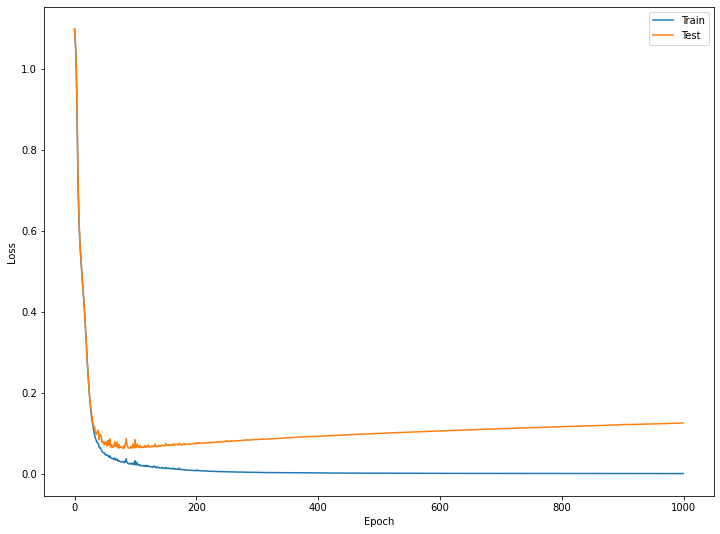

Accuracy Train: 100.0%
 Accuracy Test: 97.3%


In [7]:
"""Training!"""
# contains for losses
train_loss_x = []
train_loss_y = []
test_loss_x = []
test_loss_y = []

n_batch = n_train // batch_size

for i in range(epoch):
  # evaluate losses
  forward_propagation(input_train)
  loss_train = get_loss(correct_train, n_train)
  forward_propagation(input_test)
  loss_test = get_loss(correct_test, n_test)

  train_loss_x.append(i)
  train_loss_y.append(loss_train)
  test_loss_x.append(i)
  test_loss_y.append(loss_test)

  if i%interval == 0:
    print('Epoch:'+str(i)+'/'+str(epoch),
       'train_loss:'+str(round(loss_train,6)),
       'test_loss:'+str(round(loss_test,6)))
  
  # set batch & train
  index_random = np.arange(n_train)
  np.random.shuffle(index_random)

  for j in range(n_batch):
    # set batch
    mb_index = index_random[j*batch_size:(j+1)*batch_size]
    x = input_train[mb_index,:]
    t = correct_train[mb_index,:]

    # training 
    forward_propagation(x)
    backpropagation(t)
    update_wb()
  
# plot
plt.figure(figsize=(12,9))
plt.plot(train_loss_x, train_loss_y, label='Train')
plt.plot(test_loss_x, test_loss_y, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# accuracy
forward_propagation(input_train)
count_train = get_accuracy(correct_train, output_layer.y)
forward_propagation(input_test)
count_test = get_accuracy(correct_test, output_layer.y)

print('Accuracy Train:', str(round(count_train/n_train*100,1))+'%\n',
   'Accuracy Test:', str(round(count_test/n_test*100,1))+'%')

## Optimization
### Dropout
### AdaGrad
$h \leftarrow h + (\dfrac{\partial E}{\partial w})^2$  
  
$w \leftarrow w - \eta \dfrac{1}{\sqrt h}\dfrac{\partial E}{\partial w}$

In [8]:
# AdaGrad
class AdaGrad:
  def __init__(self, n_upper, n):
    self.w = wb_width * np.random.randn(n_upper, n)
    self.b = wb_width * np.random.randn(n)

    self.h_w = np.zeros((n_upper,n)) + 1e-8
    self.h_b = np.zeros(n) + 1e-8
  
  def update(self, eta):
    self.h_w += self.grad_w**2
    self.w -= eta * self.grad_w / np.sqrt(self.h_w)

    self.h_b += self.grad_b**2
    self.b -= eta * self.grad_b / np.sqrt(self.h_b)

# Dropout
class Dropout:
  def __init__(self, dropout_ratio):
    self.dropout_ratio = dropout_ratio
  
  def forward(self, x, dropout_on):
    if dropout_on:
      rand = np.random.rand(*x.shape)
      self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
      self.y = x * self.dropout
    
    else:
      self.y = (1 - self.dropout_ratio) * x
  
  def backward(self, grad_y):
    self.grad_x = grad_y * self.dropout

# layer class
class MiddleLayer(AdaGrad):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.where(self.u < 0, 0.01*self.u, self.u)
  
  def backward(self, grad_y):
    delta = grad_y*np.where(self.u < 0, 0.01, 1)
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)

class OutputLayer(AdaGrad):
  def forward(self, x):
    self.x = x
    u = np.dot(x, self.w) + self.b
    self.y = np.exp(u) / np.sum(np.exp(u), axis=1, keepdims=True)
  
  def backward(self, t):
    delta = self.y - t
    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)
    self.grad_x = np.dot(delta, self.w.T)

# create network
middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)

# define process
def forward_propagation(x, dropout_on):
  middle_layer_1.forward(x)
  dropout_1.forward(middle_layer_1.y, dropout_on)
  middle_layer_2.forward(dropout_1.y)
  dropout_2.forward(middle_layer_2.y, dropout_on)
  output_layer.forward(dropout_2.y)

def backpropagation(t):
  output_layer.backward(t)
  dropout_2.backward(output_layer.grad_x)
  middle_layer_2.backward(dropout_2.grad_x)
  dropout_1.backward(middle_layer_2.grad_x)
  middle_layer_1.backward(dropout_1.grad_x)

Epoch:0/1000 train_loss:1.097691 test_loss:1.098092
Epoch:100/1000 train_loss:0.297556 test_loss:0.28965
Epoch:200/1000 train_loss:0.215237 test_loss:0.208426
Epoch:300/1000 train_loss:0.159202 test_loss:0.157716
Epoch:400/1000 train_loss:0.123315 test_loss:0.13029
Epoch:500/1000 train_loss:0.101629 test_loss:0.112642
Epoch:600/1000 train_loss:0.087969 test_loss:0.100333
Epoch:700/1000 train_loss:0.07853 test_loss:0.094213
Epoch:800/1000 train_loss:0.070289 test_loss:0.090259
Epoch:900/1000 train_loss:0.064711 test_loss:0.085502


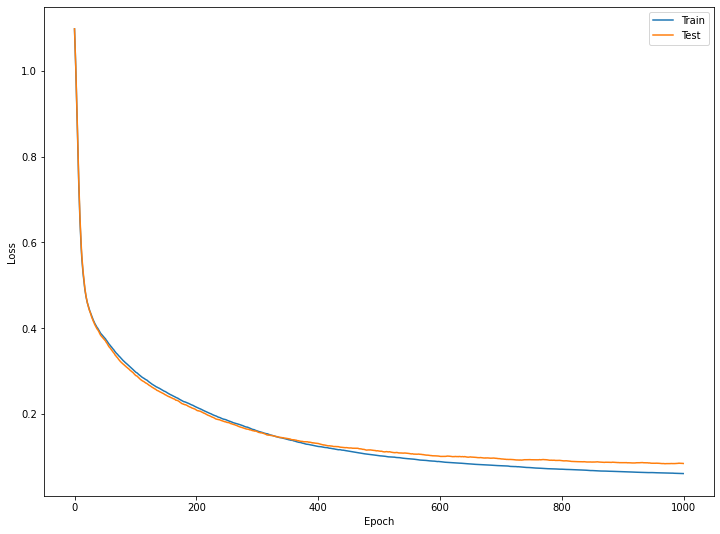

Accuracy Train: 98.7%
 Accuracy Test: 96.0%


In [9]:
"""Training!"""
# contains for losses
train_loss_x = []
train_loss_y = []
test_loss_x = []
test_loss_y = []

n_batch = n_train // batch_size

for i in range(epoch):
  # evaluate losses
  forward_propagation(input_train, False)
  loss_train = get_loss(correct_train, n_train)
  forward_propagation(input_test, False)
  loss_test = get_loss(correct_test, n_test)

  train_loss_x.append(i)
  train_loss_y.append(loss_train)
  test_loss_x.append(i)
  test_loss_y.append(loss_test)

  if i%interval == 0:
    print('Epoch:'+str(i)+'/'+str(epoch),
       'train_loss:'+str(round(loss_train,6)),
       'test_loss:'+str(round(loss_test,6)))
  
  # set batch & train
  index_random = np.arange(n_train)
  np.random.shuffle(index_random)

  for j in range(n_batch):
    # set batch
    mb_index = index_random[j*batch_size:(j+1)*batch_size]
    x = input_train[mb_index,:]
    t = correct_train[mb_index,:]

    # training 
    forward_propagation(x, True)
    backpropagation(t)
    update_wb()
  
# plot
plt.figure(figsize=(12,9))
plt.plot(train_loss_x, train_loss_y, label='Train')
plt.plot(test_loss_x, test_loss_y, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# accuracy
forward_propagation(input_train, False)
count_train = get_accuracy(correct_train, output_layer.y)
forward_propagation(input_test, False)
count_test = get_accuracy(correct_test, output_layer.y)

print('Accuracy Train:', str(round(count_train/n_train*100,1))+'%\n',
   'Accuracy Test:', str(round(count_test/n_test*100,1))+'%')